! /usr/local/anaconda3/envs/numpy_env/bin/python -m pip install little_mallet_wrapper


In [3]:
import tomotopy as tp
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path
import pandas as pd
import spacy
import matplotlib.pyplot as plt


In [4]:
directory = "../../2_Preprocessing/Corpus_deepseek_cleaned/"

In [5]:
files = glob.glob(f"{directory}/*.txt")

In [6]:
training_data = []
original_texts = []
titles = []

for file in files:
    text = open(file, encoding='utf-8').read()
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove')
    training_data.append(processed_text)
    original_texts.append(text)
    titles.append(Path(file).stem)
print(titles[:10])


['What_is_DeepSeek,_the_Chinese_AI_startup_that_shoo', 'Chinese_AI_disrupter_DeepSeek_claims_top_spot_in_U', 'Which_countries_have_banned_DeepSeek_and_why?', 'Global_AI_rivalry_is_a_dangerous_game', 'DeepSeek_just_blew_up_the_AI_industry’s_narrative_', 'OpenAI_Says_DeepSeek_May_Have_Improperly_Harvested', 'They_Invested_Billions._Then_the_A.I._Script_Got_F', 'AI_giants_Baidu,_OpenAI_offer_their_chatbots_for_f', 'DeepSeek_banned_from_Australian_government_devices', 'DeepSeek_AI_shakes_American_swagger_and_upends_ass']


In [11]:
len(training_data), len(original_texts), len(titles)

(115, 115, 115)

Train Topic Modelling

In [14]:
# --- 1. Define your custom stopwords ---
custom_stopwords = set([
    'deepseek', 'china', 'chinese', 'say', 'also', 'one', 'new', 'would', 'could', 'use','openai',
])

# --- 2. Load SpaCy for lemmatization (optional but recommended) ---
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    """
    Tokenizes, lowercases, removes stopwords, keeps only alphabetic tokens, and lemmatizes.
    """
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.is_alpha and token.text not in custom_stopwords]

# --- 3. Preprocess all documents ---
cleaned_training_data = [preprocess(text) for text in training_data]

# --- 4. Initialize the LDA model ---
num_topics = 3
num_topic_words = 10
model = tp.LDAModel(k=num_topics)

# --- 5. Add preprocessed documents ---
for doc in cleaned_training_data:
    model.add_doc(doc)

# --- 6. Train the model ---
print("Topic Model Training...\n")
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

# --- 7. Print topic results ---
print("\nTopic Model Results:\n")
topics = []
topic_individual_words = []

for topic_number in range(num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n{topic_words}\n")


Topic Model Training...

Iteration: 0	Log-likelihood: -8.41845235160245
Iteration: 10	Log-likelihood: -8.222321748159626
Iteration: 20	Log-likelihood: -8.157657204207693
Iteration: 30	Log-likelihood: -8.108242964629214
Iteration: 40	Log-likelihood: -8.091545040067302
Iteration: 50	Log-likelihood: -8.07901411432534
Iteration: 60	Log-likelihood: -8.075932096228673
Iteration: 70	Log-likelihood: -8.075252309645299
Iteration: 80	Log-likelihood: -8.069024093424725
Iteration: 90	Log-likelihood: -8.064334894610282

Topic Model Results:

✨Topic 0✨
like trump time claim take many give well large get

✨Topic 1✨
model company tech chip technology market make nvidia cost year

✨Topic 2✨
app government chatbot datum google information see include user chatgpt



Topic Model Results:

✨Topic 0✨
technology market nvidia intelligence trump may stock power take datum

✨Topic 1✨
model company tech make cost year like industry chip firm

✨Topic 2✨
app government chatgpt chatbot question people information include user ban

In [15]:
#  Here do manual topic labeling, which is a standard step after running LDA (or any topic model).
# Why we do this
# LDA gives us lists of words per topic, but these lists are not human-friendly.
# A human interprets the top words and assigns a short descriptive label.
#This makes visualizations (like heatmap) much clearer.

manual_labels = [
    "Technology & AI Trends",     # Topic 0
    "Companies & Economy",        # Topic 1
    "Politics & Government"       # Topic 2
]


In [16]:
# Load topic distributions
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

# Make functions for displaying top documents. The get_top_docs() function is taken from Maria Antoniak’s Little Mallet Wrapper

In [20]:
from IPython.display import Markdown, display
import re

def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(docs, topic_distributions, topic_index, n=5):
    
    sorted_data = sorted([(_distribution[topic_index], _document) 
                          for _distribution, _document 
                          in zip(topic_distributions, docs)], reverse=True)
    
    topic_words = topics[topic_index]
    
    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n")
    print("---")
    
    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)
        
        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')
    
    return

In [22]:
# display topic titles
get_top_docs(titles, topic_distributions, topic_index=0, n=6)

### ✨Topic 0✨

like trump time claim take many give well large get



---


✨  
**Topic Probability**: 0.5884913802146912  
**Document**: Tech_war_in_2024:_China_catches_up_fast_in_AI_race



✨  
**Topic Probability**: 0.5175161361694336  
**Document**: DeepSeek_is_decoding_Chinese_destiny



✨  
**Topic Probability**: 0.5156475901603699  
**Document**: Oh,_I’m_sorry,_tech_bros_–_did_DeepSeek_copy_your_



✨  
**Topic Probability**: 0.4767780900001526  
**Document**: UK_will_not_be_able_to_resist_China's_tech_dominan



✨  
**Topic Probability**: 0.43912166357040405  
**Document**: India_AI:_As_DeepSeek_and_ChatGPT_surge,_is_Delhi_



✨  
**Topic Probability**: 0.4284614622592926  
**Document**: DeepSeek_vs_ChatGPT_-_how_do_they_compare?



In [24]:
get_top_docs(titles, topic_distributions, topic_index=1, n=5)

### ✨Topic 1✨

model company tech chip technology market make nvidia cost year



---


✨  
**Topic Probability**: 0.7373557686805725  
**Document**: Nvidia_says_AI_chip_sales_strong_despite_DeepSeek_



✨  
**Topic Probability**: 0.7032690048217773  
**Document**: Meet_DeepSeek:_the_Chinese_start-up_that_is_changi



✨  
**Topic Probability**: 0.6875030398368835  
**Document**: How_Did_DeepSeek_Build_Its_A.I._With_Less_Money?



✨  
**Topic Probability**: 0.6843668818473816  
**Document**: Chinese_start-up_DeepSeek_launches_AI_model_that_o



✨  
**Topic Probability**: 0.6743515133857727  
**Document**: The_story_behind_DeepSeek’s_breakthrough



In [41]:
# Output CSV File
import pandas as pd

# Create a DataFrame with document titles and topic distributions
topic_results = []
for title, topic_distribution in zip(titles, topic_distributions):
    topic_results.append({'document': title, 'topic_distribution': topic_distribution})

df = pd.DataFrame(topic_results)

# Assign manual labels to columns
# Each column represents the probability of a topic in that document
df[manual_labels] = pd.DataFrame(df['topic_distribution'].tolist(), index=df.index)

# Drop the original 'topic_distribution' column
df = df.drop('topic_distribution', axis='columns')

df

,document,Technology & AI Trends,Companies & Economy,Politics & Government
0,"What_is_DeepSeek,_the_Chinese_AI_startup_that_...",0.243440,0.114454,0.642106
1,Chinese_AI_disrupter_DeepSeek_claims_top_spot_...,0.315544,0.171450,0.513006
2,Which_countries_have_banned_DeepSeek_and_why?,0.623653,0.131011,0.245336
3,Global_AI_rivalry_is_a_dangerous_game,0.267881,0.372664,0.359455
4,DeepSeek_just_blew_up_the_AI_industry’s_narrat...,0.163651,0.193213,0.643136
...,...,...,...,...
110,US_tech_stocks_partly_recover_after_Trump_says...,0.472375,0.090150,0.437475
111,Diving_into_DeepSeek:_inside_the_7_February_Gu...,0.386523,0.299281,0.314195
112,Hong_Kong_stocks_gain_on_valuation_focus_as_De...,0.511680,0.107302,0.381018
113,Nvidia_and_Microsoft_shares_steady_after_DeepS...,0.326230,0.210743,0.463027


In [36]:
# Save to CSV
df.to_csv("../output/topic_results.csv", index=False, encoding="utf-8")


Choose a topic from the results above and write down its corresponding topic number below.

Topic: Technology & AI Trends


In [37]:
df.sort_values(by='Technology & AI Trends', ascending=False)[:6]

,document,Technology & AI Trends,Companies & Economy,Politics & Government
74,DeepSeek_blocked_from_some_app_stores_in_Italy...,0.743535,0.085850,0.170615
8,DeepSeek_banned_from_Australian_government_dev...,0.679981,0.213594,0.106424
85,DeepSeek:_South_Korea_temporarily_bans_AI_app_...,0.666257,0.136314,0.197429
2,Which_countries_have_banned_DeepSeek_and_why?,0.623653,0.131011,0.245336
17,South_Korea_bans_new_downloads_of_China's_Deep...,0.612828,0.132057,0.255114
34,OpenAI_‘reviewing’_allegations_that_its_AI_mod...,0.598538,0.079680,0.321782


Explore Heatmap of Topics and Texts
We can visualize and compare these topic probability distributions with a heatmap by using the little_mallet_wrapper.plot_categories_by_topics_heatmap() function.

We need a list of target_labels, the sample of texts that we’d like to visualize and compare with the heatmap. Below we make our list of desired target labels.

In [26]:
target_labels = ["US_tech_stocks_plunge_on_China_AI’s_unexpectedly_s",
                 "Hong_Kong_stocks_gain_on_valuation_focus_as_DeepSe",
                 "A_shocking_Chinese_AI_advancement_called_DeepSeek_",
                 "China’s_DeepSeek_causes_rout_among_AI-linked_stock",
                 "DeepSeek_breakthrough,_Nvidia_stock_rout_raise_con",
                 "My_Take_|_Chinese_start-up_DeepSeek_looks_set_to_r"
]

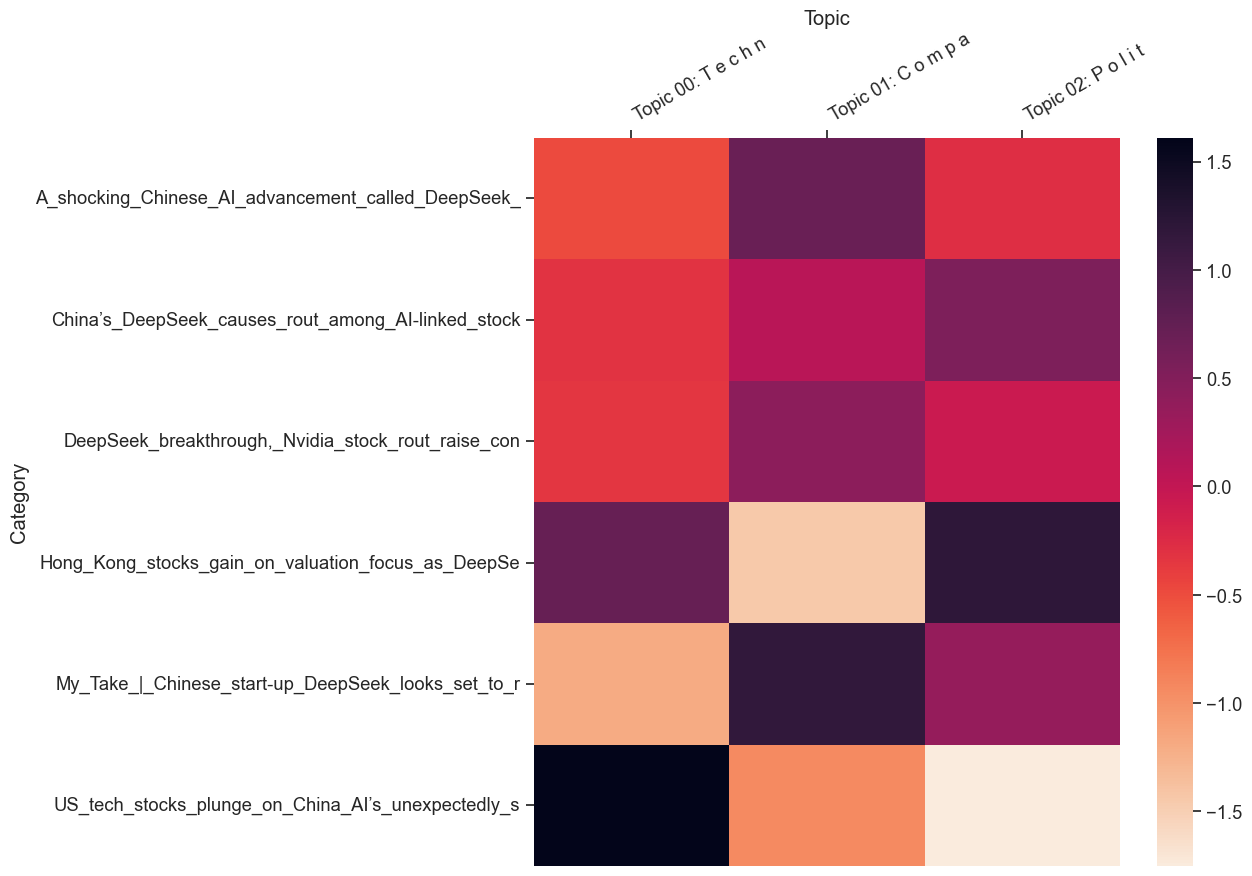

In [39]:
import matplotlib.pyplot as plt
import os

# Plot the heatmap
little_mallet_wrapper.plot_categories_by_topics_heatmap(
    titles,
    topic_distributions,
    manual_labels,
    target_labels=target_labels,
    dim=(13, 9)
)

# Get the current figure and axes
fig = plt.gcf()
ax = plt.gca()


plt.close(fig)


In [42]:
# make a random list of target labels
import random
target_labels = random.sample(titles, 10)

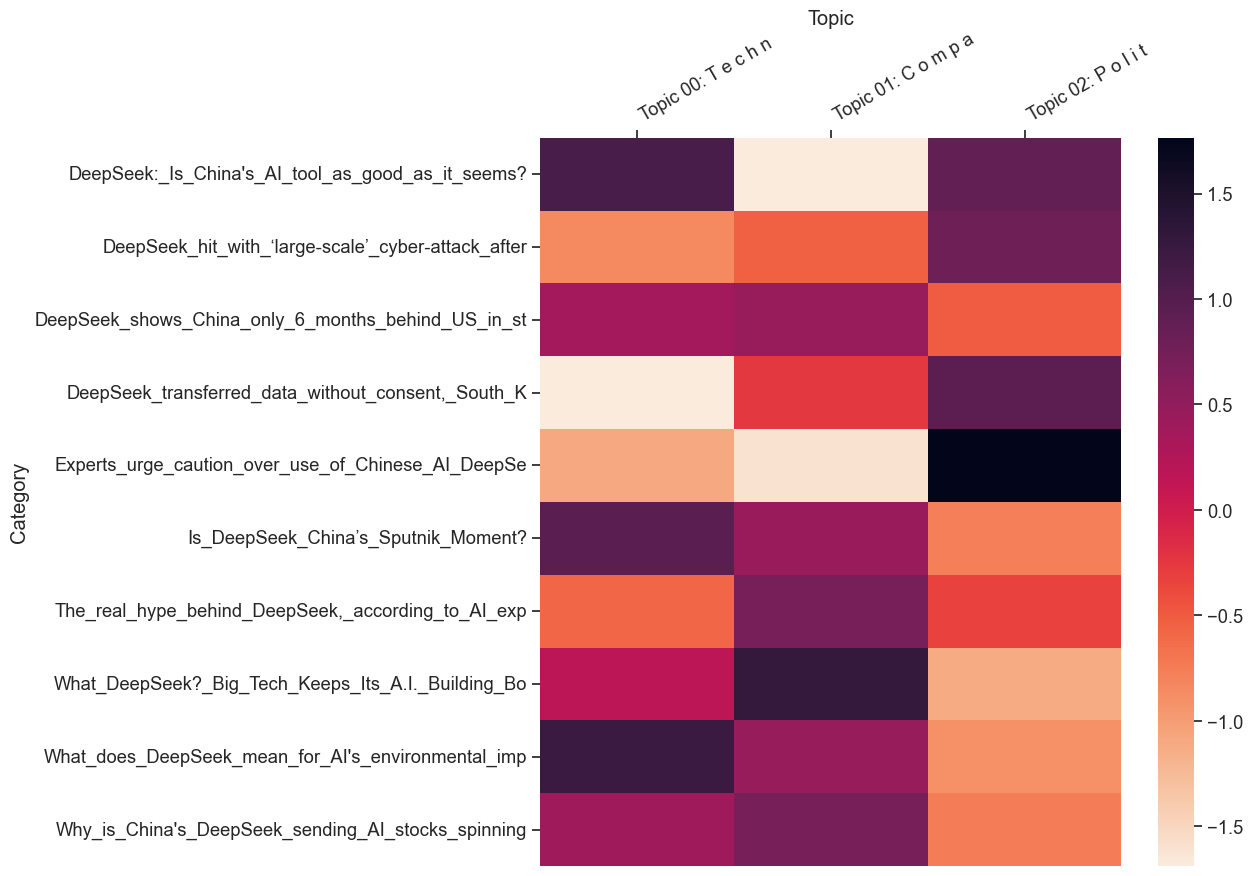

In [46]:
import matplotlib.pyplot as plt

little_mallet_wrapper.plot_categories_by_topics_heatmap(titles,
                                      topic_distributions,
                                      manual_labels, 
                                    
                                      target_labels=target_labels,
                                      dim= (13, 9)
                                     )
